In [1]:
from pathlib import Path
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is ready")

cuda is ready


In [3]:
DATA_DIR = Path("../../data/raw")
img_dir = Path("../../data/raw/images/image_train")
X_train = pd.read_csv(DATA_DIR/"X_train_update.csv", index_col=0)
Y_train = pd.read_csv(DATA_DIR/"Y_train_CVw08PX.csv", index_col=0)

df = X_train.join(Y_train, how="inner")

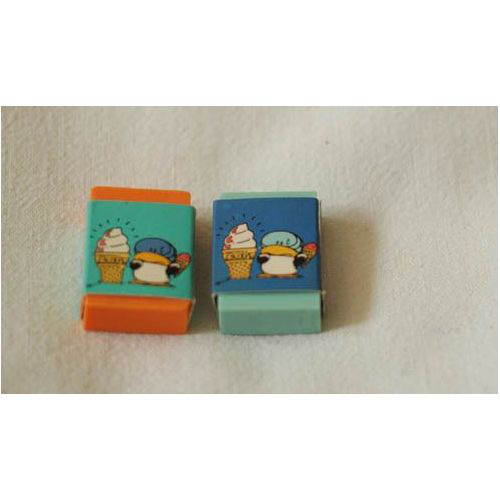

In [4]:
def get_img(index):
    row = df.iloc[index]
    image_name = f"image_{row['imageid']}_product_{row['productid']}.jpg"
    img = Image.open(img_dir/image_name)
    img_display = display(img)
    return img_display

get_img(84915)

In [5]:
preprocess = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [6]:
def get_img_data_by_index(index):
    row = df.iloc[index]
    image_name = f"image_{row['imageid']}_product_{row['productid']}.jpg"
    img = Image.open(img_dir / image_name).convert("RGB")
    img_tensor = preprocess(img)

    return img_tensor

tensor_data = get_img_data_by_index(5)
display(f"return image shape: {tensor_data.shape}")

'return image shape: torch.Size([3, 224, 224])'

'image en gray shape: torch.Size([3, 224, 224])'

'valeur en gouche haute coin:'

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

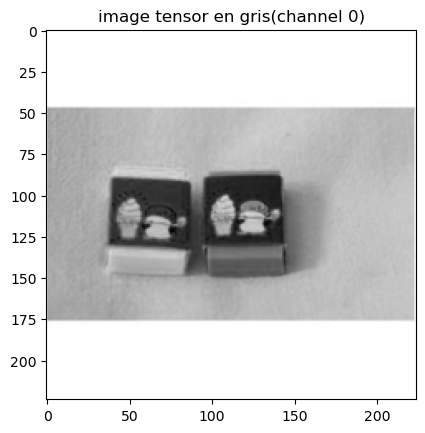

In [7]:
img_tensor = get_img_data_by_index(84915)

display(f"image en gray shape: {img_tensor.shape}")

display("valeur en gouche haute coin:")
display(img_tensor[0][0:6, 0:6])

plt.imshow(img_tensor[0], cmap="gray")
plt.title("image tensor en gris(channel 0)")
plt.show()

In [8]:
# Manual convolution with Sobel kernels
kernel_vertical = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]])

kernel_horizontal = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]])

In [9]:
def manual_convolution(img_tensor, kernel):

    # Get dimensions img_tensor, kernel_vertical
    channels, img_height, img_width = img_tensor.shape
    kernel_height, kernel_width = kernel_horizontal.shape

    # Calculate output dimensions for convolution
    output_height = img_height - kernel_height + 1
    output_width = img_width - kernel_width + 1

    # initialize output image
    output_img = np.zeros((output_height, output_width))
    
    # run convolution
    for i in range(output_height):
        for j in range(output_width):
            region = img_tensor[0, i:i+kernel_height, j:j+kernel_width].numpy()
            conv_value = np.sum(region * kernel)
            output_img[i, j] = conv_value

    return output_img

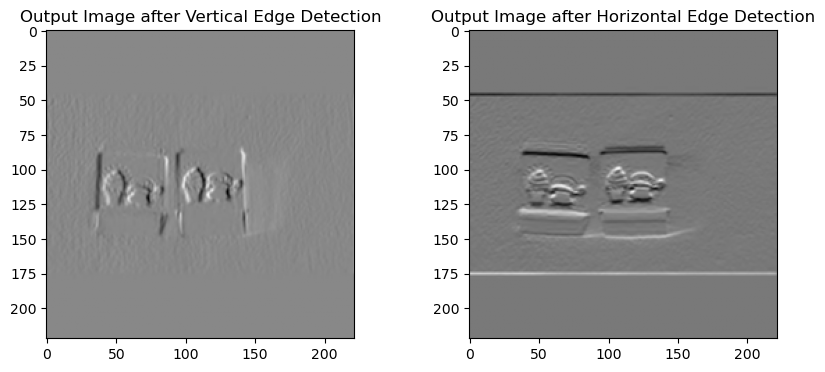

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(manual_convolution(img_tensor, kernel_vertical), cmap='gray')
axes[0].set_title("Output Image after Vertical Edge Detection")
axes[1].imshow(manual_convolution(img_tensor, kernel_horizontal), cmap='gray')
axes[1].set_title("Output Image after Horizontal Edge Detection")
result = plt.show()

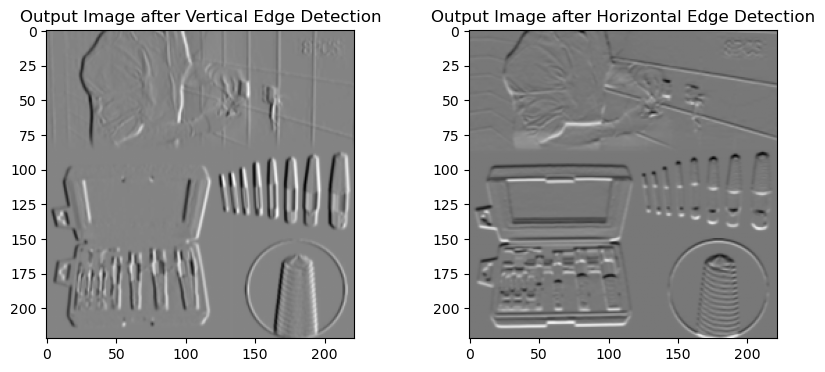

In [11]:
img_test = get_img_data_by_index(778)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(manual_convolution(img_test, kernel_vertical), cmap='gray')
axes[0].set_title("Output Image after Vertical Edge Detection")
axes[1].imshow(manual_convolution(img_test, kernel_horizontal), cmap='gray')
axes[1].set_title("Output Image after Horizontal Edge Detection")
result = plt.show()

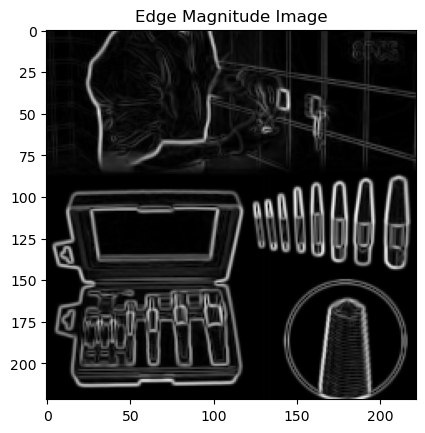

In [12]:
edge_v = manual_convolution(img_test, kernel_vertical)
edge_h = manual_convolution(img_test, kernel_horizontal)
edge_magnitude = np.sqrt(edge_v**2 + edge_h**2)
magnitude_fig = plt.imshow(edge_magnitude, cmap='gray')
plt.title("Edge Magnitude Image")
plt.show()

Before Pooling: (222, 222)
After Pooling: (111, 111)


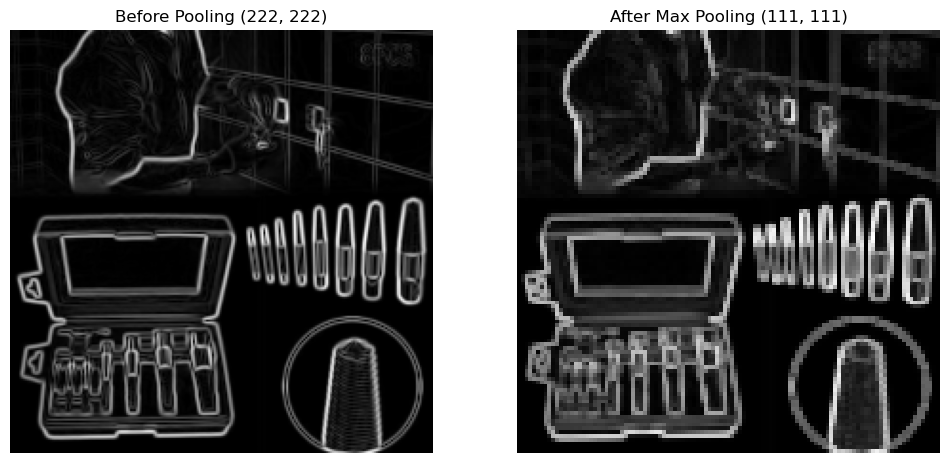

In [13]:
# pooling operation manually
def manual_max_pooling(feature_map, pool_size=2, stride=2):
    
    h, w = feature_map.shape
    
    out_h = (h - pool_size) // stride + 1
    out_w = (w - pool_size) // stride + 1
    
    output = np.zeros((out_h, out_w))
    
    for i in range(out_h):
        for j in range(out_w):
            r_start = i * stride
            r_end = r_start + pool_size
            c_start = j * stride
            c_end = c_start + pool_size
            
            region = feature_map[r_start:r_end, c_start:c_end]
            
            output[i, j] = np.max(region)
            
    return output

print(f"Before Pooling: {edge_magnitude.shape}")

pooled_edge = manual_max_pooling(edge_magnitude, pool_size=2, stride=2)

print(f"After Pooling: {pooled_edge.shape}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(edge_magnitude, cmap='gray')
plt.title(f"Before Pooling {edge_magnitude.shape}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pooled_edge, cmap='gray')
plt.title(f"After Max Pooling {pooled_edge.shape}")
plt.axis('off')

plt.show()

In [14]:
# comprendre couleur
index = 778
img_tensor = get_img_data_by_index(index)

# [1, 3, 244, 244] signifieant un batch de 1 image, 3 canaux (R,G,B), 244x244 pixels
input_batch = img_tensor.unsqueeze(0)

# tansfer to device GPU
input_batch = input_batch.to(device)

print("input batch shape:", input_batch.shape)

input batch shape: torch.Size([1, 3, 224, 224])


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Définition du détecteur 
# Il faut absolument ajouter .to(device) à la fin pour envoyer cette couche neurale sur le GPU.
blue_detector = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=1, bias=False).to(device)

# 2. Création de "recette" de poids (le filtre R=-1, G=0, B=1)
custom_weight = torch.tensor([-1.0, 0.0, 1.0]).reshape(1, 3, 1, 1).to(device)

# 3. Injection des poids manuels dans le modèle
# torch.no_grad() est utilisé pour dire à PyTorch : "Ne calcule pas de gradients pour cette opération de copier-coller".
with torch.no_grad():
    blue_detector.weight.copy_(custom_weight)

# 4. Exécution (Forward Pass)
# Maintenant que le modèle (blue_detector) et les données (input_batch) sont tous les deux sur le GPU, cela va fonctionner.
output_map = blue_detector(input_batch)

# Affichage des dimensions pour vérification
# Attention : input_batch.shape donne la taille, pas besoin d'imprimer l'objet entier
print("Dimension de l'entrée (Input Shape) :", input_batch.shape)
print("Dimension de la sortie (Output Shape) :", output_map.shape)

Dimension de l'entrée (Input Shape) : torch.Size([1, 3, 224, 224])
Dimension de la sortie (Output Shape) : torch.Size([1, 1, 224, 224])


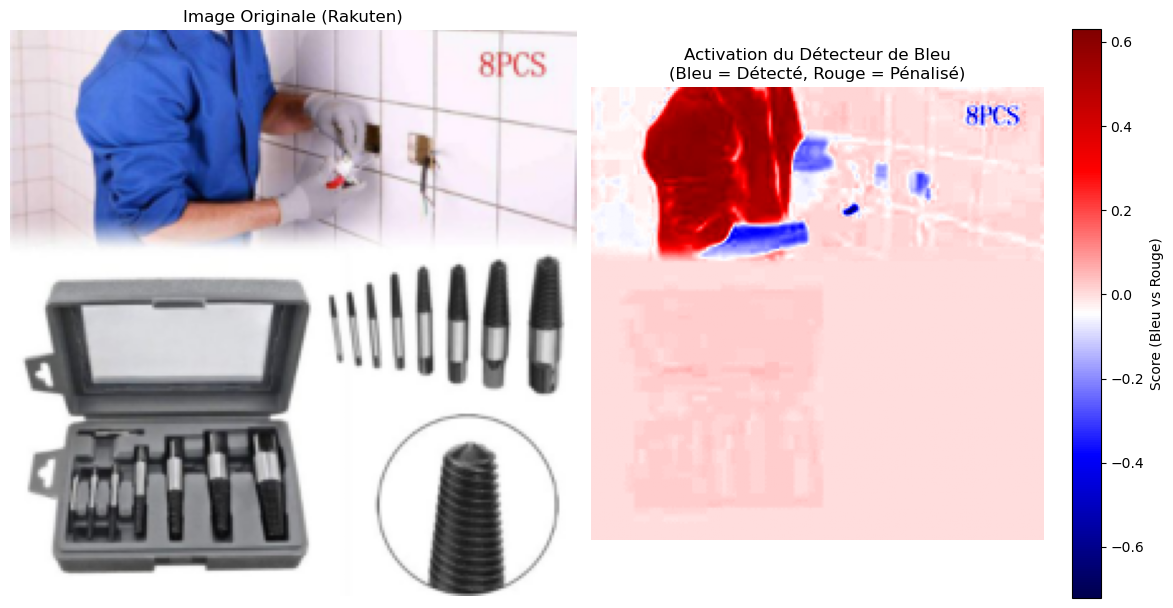

In [16]:
# Visualisation des résultats

# Préparation de l'image originale pour Matplotlib
# PyTorch utilise [Channel, Height, Width], mais Matplotlib veut [Height, Width, Channel]
# .cpu() ramène les données de la carte graphique vers la mémoire vive
# .permute(1, 2, 0) change l'ordre des dimensions
original_img_cpu = input_batch[0].cpu().permute(1, 2, 0).numpy()

# Préparation de la carte d'activation (Output Map)
# On prend la première image du batch [0] et le premier canal [0]
# .detach() est nécessaire pour dire qu'on ne fait plus d'apprentissage ici
activation_map = output_map[0, 0].detach().cpu().numpy()

# Création de la figure
plt.figure(figsize=(12, 6))

# --- Affichage de l'image originale ---
plt.subplot(1, 2, 1)
plt.imshow(original_img_cpu)
plt.title("Image Originale (Rakuten)")
plt.axis('off')

# --- Affichage de la détection de bleu ---
plt.subplot(1, 2, 2)
# On utilise la colormap 'seismic' (ou 'bwr') : 
# Le Bleu indique un score positif (forte présence de bleu)
# Le Rouge indique un score négatif (présence de rouge, pénalisée par notre poids -1)
# Le Blanc indique un score proche de 0 (couleurs neutres ou vert)
plt.imshow(activation_map, cmap='seismic') 
plt.colorbar(label='Score (Bleu vs Rouge)')
plt.title("Activation du Détecteur de Bleu\n(Bleu = Détecté, Rouge = Pénalisé)")
plt.axis('off')

plt.tight_layout()
plt.show()